<a href="https://colab.research.google.com/github/fnandocontreras/tripadvisor-reviews/blob/main/tripadvisor_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

print(tf.__version__)

2.4.1


# Downloading data from kaggle

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fcontreras","key":"05bf06923b908a5e3e01cae97a62dc0e"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s Glove.twitter.100d

ref                                                      title                                              size  lastUpdated          downloadCount  
-------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
naominguyen7/glovetwitter100d                            Glove.twitter.100d                                397MB  2017-12-28 18:26:47            315  
jdpaletto/glove-global-vectors-for-word-representation   GloVe: Global Vectors for Word Representation       1GB  2018-02-22 20:05:00           1401  
richardfourd/glovetwitter27b100d                         glove.twitter.27B.100d                            397MB  2018-01-17 01:40:41             20  
apresswala52/glovetwitter27b100d                         glove.twitter.27B.100D                            397MB  2020-07-19 05:03:00              0  
robertyoung/glove-twitter-pickles-27b-25d-50d-100d-200d  GloVe Twitter Pickles 27B - 25d, 50d,

In [6]:
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews
!kaggle datasets download -d naominguyen7/glovetwitter100d
!ls /content

 97% 5.00M/5.14M [00:00<00:00, 34.1MB/s]
100% 5.14M/5.14M [00:00<00:00, 32.8MB/s]
 99% 393M/397M [00:23<00:00, 26.0MB/s]
100% 397M/397M [00:23<00:00, 17.4MB/s]
glovetwitter100d.zip  kaggle.json  sample_data	trip-advisor-hotel-reviews.zip


In [7]:
base_path = '/content/'
df = pd.read_csv(os.path.join( base_path, 'trip-advisor-hotel-reviews.zip'))
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


# Rating counts

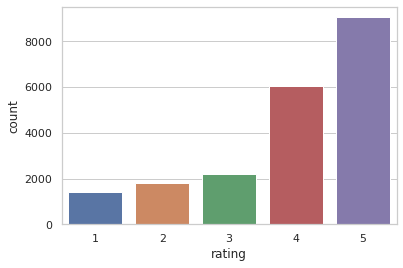

In [35]:
rating_counts = df['Rating'].value_counts()
df_counts = pd.DataFrame({'rating': rating_counts.index, 'count': rating_counts.values})

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="rating", y="count", data=df_counts)

# Exploring reviews

In [9]:
texts = df['Review'].values
ratings = df['Rating'].astype(float).values
print(texts[:5])

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unl

# Removing digits from text corpus

In [10]:
df['Review'] = df['Review'].apply(lambda x: re.sub('\d+', '', x))

# Removing stopwords

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
  tokens = word_tokenize(sentence)
  tokens = [tok for tok in tokens if not tok in stop_words]
  return ' '.join(tokens)

df['Review'] = df['Review'].apply(lambda x: remove_stop_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Splitting dataset in train/test

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(texts, ratings, test_size=0.05, shuffle=True)

# Tokenizing reviews

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
max_sequence_len = max([len(x) for x in train_sequences])

train_sequences = np.array(pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post'))
test_sequences = np.array(pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post'))

# Loading Glove word embedding vectors

In [15]:
from zipfile import ZipFile
import io

embedding_dim = 100

embeddings_index = {};
with ZipFile(os.path.join(base_path, 'glovetwitter100d.zip'), 'r') as zip:
  with io.TextIOWrapper(zip.open(f"glove.twitter.27B.{embedding_dim}d.txt"), encoding="utf-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

oov_words = []

embeddings_matrix = np.zeros((total_words, embedding_dim));
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word);
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector;
  else :
    oov_words.append(word)

oov_words = list(set(oov_words))

# Autocorrecting misspelled words

In [16]:
!pip install -q pyspellchecker

from spellchecker import SpellChecker

     |████████████████████████████████| 2.7MB 9.7MB/s 


In [17]:
oov_words[:20]

['tourests',
 'positivesgreat',
 'thomsour',
 'toppest',
 'hisortic',
 'somewaht',
 'absolutelyloved',
 'quaintly',
 'postmodernist',
 'metreon',
 'resturantsthe',
 'busiers',
 'prodruding',
 'aguaviva',
 'talled',
 'dewamarco',
 'visisted',
 'surroundingus',
 'butthe',
 'luxurty']

In [18]:
import json

def get_autocorrections(oov_words):
  spell = SpellChecker()
  auto_corrections = {}

  for word in oov_words:
      # Get the one `most likely` answer
      auto_corrections[word] = spell.correction(word)
      if len(auto_corrections) % 100 == 0:
        print(f'corrected: {len(auto_corrections)} words from a total of {len(oov_words)}')
  
  with open(os.path.join(base_path, 'oov_words.json'), 'w') as json_file:
    json.dump(auto_corrections, json_file)

def load_autocorrections_from_json():
  with open(os.path.join(base_path, 'oov_words.json')) as json_file:
    return json.load(json_file)


In [19]:
#auto_corrections = get_autocorrections(oov_words)

In [20]:
files.upload()
! cp oov_words.json ~/content/

Saving oov_words.json to oov_words.json
cp: cannot create regular file '/root/content/': Not a directory


In [21]:
auto_corrections = load_autocorrections_from_json()

# Adding word vectors for Out of Vocabulary words

In [22]:
for oov_word, correction in auto_corrections.items():
  embedding_vector = embeddings_index.get(correction);
  if embedding_vector is not None:
    embeddings_matrix[word_index[oov_word]] = embedding_vector

# Building model

In [27]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(total_words, embedding_dim, input_length, embeddings_matrix):
  model = Sequential([
  tf.keras.layers.Embedding(total_words, embedding_dim, input_length=input_length, weights=[embeddings_matrix], trainable=False),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])
  model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mae'])
  return model
  

In [28]:
model = build_model(total_words, embedding_dim, max_sequence_len, embeddings_matrix)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1933, 100)         4955700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

# Training model

In [29]:
!pip install -q livelossplot
from livelossplot import PlotLossesKeras

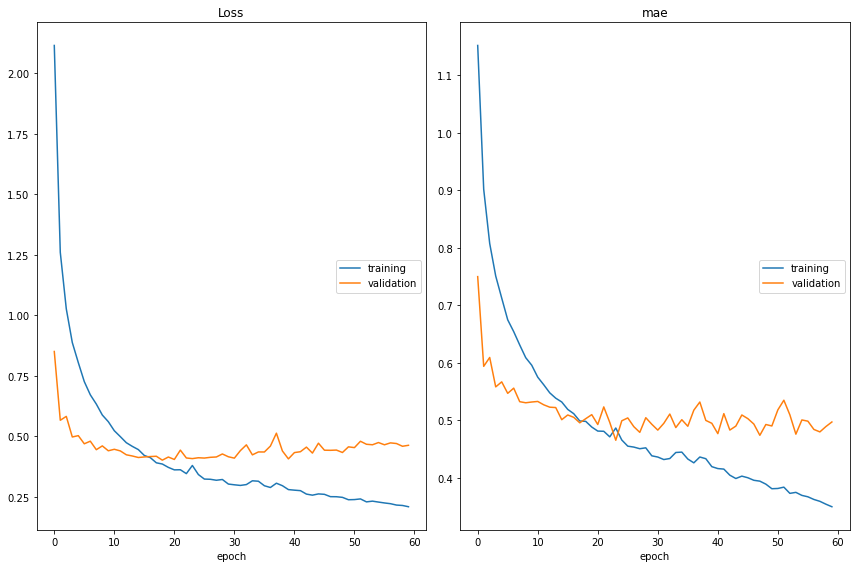

Loss
	training         	 (min:    0.210, max:    2.115, cur:    0.210)
	validation       	 (min:    0.402, max:    0.851, cur:    0.464)
mae
	training         	 (min:    0.350, max:    1.152, cur:    0.350)
	validation       	 (min:    0.465, max:    0.750, cur:    0.497)


In [30]:
history = model.fit(
    x=train_sequences, 
    y=y_train, 
    validation_split=0.05, 
    epochs=60, 
    callbacks=[PlotLossesKeras()],
    shuffle=True)

In [31]:
from sklearn.metrics import accuracy_score

yhat = model(test_sequences)
preds = np.round(yhat).astype(int)

df_preds = pd.DataFrame({
    'y_true': y_test.astype(int),
    'y_pred': preds[:,0], 
    'y_hat': yhat[:,0],
    'mae': np.abs(y_test - yhat[:,0]),
    'review': x_test
    })
print('total predictions', len(df_preds))
df_errors = df_preds[df_preds['y_true'] != df_preds['y_pred']]
print('total errors', len(df_errors))
print('accuracy score', accuracy_score(df_preds['y_true'], df_preds['y_pred']))


total predictions 1025
total errors 407
accuracy score 0.6029268292682927


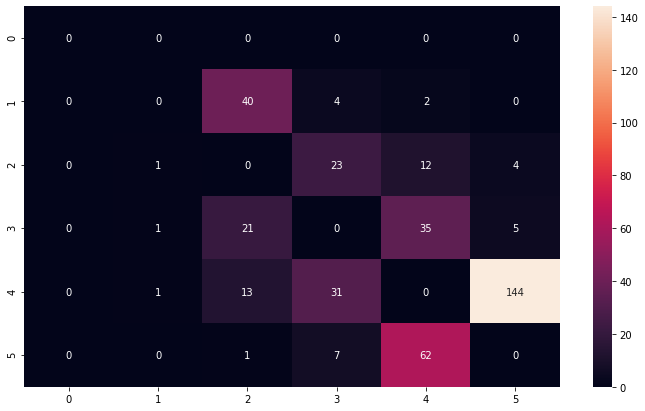

In [33]:


conf_matrix = tf.math.confusion_matrix(
    df_errors['y_true'].values, 
    df_errors['y_pred'].values
)

plt.figure(figsize = (12,7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.show()